In [1]:
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
from torch.distributions.categorical import Categorical

from matplotlib import pyplot as plt

In [2]:
class BasicParameters(nn.Module):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        
    @property
    def shape(self):
        return self().shape

    def forward(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def rebatch(self, input):
        return input


In [3]:
class NUTS3(nn.Module):
    def __init__(self,
                 params,
                 energy_fn,
                ):
        
        super().__init__()
        self.params = params
        self.energy_fn  = energy_fn
        
        self.d_max = 1000.
        
    def calc_energy(self):
        energy = self.energy_fn(self.params())
        energy = self.params.rebatch( energy )
        return energy

    def leapfrog(self, theta, r, epsilon):
        
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
            theta = theta + r.mul(epsilon)
            
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
        return theta, r, energy
        
    def buildtree(self, theta, r, u, v, j, epsilon):
        print(f'current j: {j}')
        if j == 0:
            theta_p, r_p, energy_p = self.leapfrog(theta, r, epsilon)
            batch_dot = torch.einsum('bs,bs->b', r_p.flatten(1), r_p.flatten(1))
            hamilton  = energy_p + batch_dot.div(2.)
            n_p = (u <= torch.exp(-hamilton)).type(torch.long)
            s_p = (torch.log(u).add(-self.d_max) < -hamilton).type(torch.long)
            #print(f'inner j: {j}')
            #print(f'log u: {u.log()}, -H: {-hamilton}')
            #print(theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p, sep='\n')
            return theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p
        
        else:
            #print(f'inner j: {j}')
            bt_pack = self.buildtree(theta, r, u, v, j-1, epsilon)
            theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p = bt_pack
            #[print(a) for a in bt_pack]
            if s_p.sum() > 0:
                if v == -1:
                    bt_pack = self.buildtree(theta_r, r_r, u, v, j-1, epsilon)
                    theta_r, r_r, _, _, theta_pp, n_pp, s_pp = bt_pack
                    
                else:
                    bt_pack = self.buildtree(theta_f, r_f, u, v, j-1, epsilon)
                    _, _, theta_f, r_f, theta_pp, n_pp, s_pp = bt_pack
                
                update_flag = torch.rand(n_pp.size(), dtype=torch.float, 
                                         layout=n_pp.layout, device=n_pp.device)
                update_flag = update_flag < n_pp.div( n_p + n_pp )
                update_flag = torch.logical_and(update_flag, s_p.ge(1) )
                theta_p[ update_flag ] = theta_pp[ update_flag ]
                s_p = s_p * s_pp * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                        .ge(0.).type(torch.long) * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                        .ge(0.).type(torch.long)
                n_p = n_p + n_pp
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p)
            return theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p
        
    def init_trajectory(self, theta):
        with torch.no_grad():
            r_0 = torch.randn_like( theta )
            energy_0 = self.calc_energy()
            batch_dot= torch.einsum('bs,bs->b', r_0.flatten(1), r_0.flatten(1))
            hamilton = energy_0 + batch_dot.div(2.)
            u   = torch.rand_like( hamilton ).mul( torch.exp(-hamilton) )
            
            theta_r, theta_f = theta, theta
            r_r, r_f = r_0, r_0
            j = 0
            theta_m = theta
            n = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
            s = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
        return u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s
    
    def sample_trajectory(self, theta, epsilon):
        u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s = self.init_trajectory(theta)
        while s.sum() >= 1:
            v = torch.randn([1], dtype=torch.float, layout=theta.layout, device=theta.device) \
                  .ge(0.).mul(2.).add(-1.)
            if v < 0:
                theta_r, r_r, _, _, theta_p, n_p, s_p = self.buildtree(theta_r, r_r, u, v, j, epsilon)
            else:
                _, _, theta_f, r_f, theta_p, n_p, s_p = self.buildtree(theta_f, r_f, u, v, j, epsilon)
            
            #print('traj results:')
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p, sep='\n')
            update_flag = torch.rand_like(n.type(torch.float))
            update_flag = update_flag <= torch.minimum( n / n_p, torch.ones_like(n.type(torch.float)) )
            update_flag = torch.logical_and( update_flag, s.ge(1) )
            update_flag = torch.logical_and( update_flag, s_p.ge(1) )
            #print(f'update_flag: {update_flag}')
            theta_m[ update_flag ] = theta_p[ update_flag ]
            
            n = n + n_p
            s = s * s_p * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                  .ge(0.).type(torch.long) * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                  .ge(0.).type(torch.long)
            j = j + 1
        
        return theta_m.detach().clone()
    
    def collect_samples(self, epsilon, n_samples=1):
        samples = []
        theta_m = self.params.theta.clone().detach()
        for m in range(n_samples):
            theta_m = self.sample_trajectory( theta_m, epsilon )
            samples.append( theta_m )
        return samples


In [4]:
def my_energy(in_tensor):
    return in_tensor.pow(2).sum(dim=(1,2))

In [5]:
my_params = BasicParameters(
    nn.Parameter(torch.randn([2,2,1]))
)

my_sampler = NUTS3( my_params, my_energy )

In [6]:
test_theta = torch.randn([2,2,1])
test_r     = torch.randn([2,2,1])
print(test_theta)
print(test_r)
print(my_sampler.params.theta)

tensor([[[ 0.9882],
         [-1.4933]],

        [[-0.6341],
         [ 1.2090]]])
tensor([[[ 1.1653],
         [ 1.7718]],

        [[-1.0319],
         [-0.7554]]])
Parameter containing:
tensor([[[0.4484],
         [0.6848]],

        [[0.0828],
         [0.9102]]], requires_grad=True)


In [7]:
my_sampler.calc_energy()

tensor([0.6700, 0.8352], grad_fn=<SumBackward1>)

In [8]:
my_sampler.params().pow(2).sum(dim=(1,2))

tensor([0.6700, 0.8352], grad_fn=<SumBackward1>)

In [9]:
torch.einsum('bs,bs->b', test_r.flatten(1),test_r.flatten(1)).div(2.)

tensor([2.2487, 0.8177])

In [10]:
( my_sampler.calc_energy() + torch.einsum('bs,bs->b', test_r.flatten(1),test_r.flatten(1)).div(2.) ).mul(-1.).exp()

tensor([0.0540, 0.1915], grad_fn=<ExpBackward>)

In [11]:
init_vals = my_sampler.init_trajectory(test_theta)
check_u, check_theta_r, check_r_r, check_theta_f, check_r_f, check_j, check_theta_m, check_n, check_s = init_vals
init_vals

(tensor([0.0073, 0.2059]),
 tensor([[[ 0.9882],
          [-1.4933]],
 
         [[-0.6341],
          [ 1.2090]]]),
 tensor([[[ 1.4642],
          [-0.3363]],
 
         [[ 0.2431],
          [-0.6788]]]),
 tensor([[[ 0.9882],
          [-1.4933]],
 
         [[-0.6341],
          [ 1.2090]]]),
 tensor([[[ 1.4642],
          [-0.3363]],
 
         [[ 0.2431],
          [-0.6788]]]),
 0,
 tensor([[[ 0.9882],
          [-1.4933]],
 
         [[-0.6341],
          [ 1.2090]]]),
 tensor([1, 1]),
 tensor([1, 1]))

In [12]:
v = torch.randn([1], dtype=torch.float, layout=test_theta.layout, device=test_theta.device) \
                  .ge(0.).mul(2.).add(-1.)
v

tensor([1.])

In [13]:
check_theta_r

tensor([[[ 0.9882],
         [-1.4933]],

        [[-0.6341],
         [ 1.2090]]])

In [14]:
my_sampler.buildtree(check_theta_r, check_r_r, init_vals[0], v, 4, 1e-1)

current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0


(tensor([[[ 1.3907],
          [-1.3882]],
 
         [[-0.6035],
          [ 1.1290]]]),
 tensor([[[ 1.2529],
          [-0.0358]],
 
         [[ 0.3668],
          [-0.9126]]]),
 tensor([[[ 0.1660],
          [ 0.7716]],
 
         [[ 0.5380],
          [-1.1431]]]),
 tensor([[[-2.0080],
          [ 1.8346]],
 
         [[ 0.5323],
          [-0.8771]]]),
 tensor([[[ 1.3907],
          [-1.3882]],
 
         [[-0.6035],
          [ 1.1290]]]),
 tensor([16,  0]),
 tensor([0, 1]))

In [15]:
init_vals = my_sampler.init_trajectory(test_theta)
check_u, check_theta_r, check_r_r, check_theta_f, check_r_f, check_j, check_theta_m, check_n, check_s = init_vals
init_vals

(tensor([0.0309, 0.0137]),
 tensor([[[ 0.9882],
          [-1.4933]],
 
         [[-0.6341],
          [ 1.2090]]]),
 tensor([[[ 1.9796],
          [-1.0035]],
 
         [[-0.4567],
          [-0.3332]]]),
 tensor([[[ 0.9882],
          [-1.4933]],
 
         [[-0.6341],
          [ 1.2090]]]),
 tensor([[[ 1.9796],
          [-1.0035]],
 
         [[-0.4567],
          [-0.3332]]]),
 0,
 tensor([[[ 0.9882],
          [-1.4933]],
 
         [[-0.6341],
          [ 1.2090]]]),
 tensor([1, 1]),
 tensor([1, 1]))

In [16]:
my_sample = my_sampler.sample_trajectory(check_theta_r, 1e-1)

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0


In [17]:
my_sample

tensor([[[ 1.1301],
         [-1.5145]],

        [[-0.3541],
         [ 1.4071]]])

In [18]:
my_samples = my_sampler.collect_samples(1e-1,1000)

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0

current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3

current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1

current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0

current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3

current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0

current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3

current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1

current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0

current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 4
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0

current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 3
current j: 2
current j: 1
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0
current j: 0
current j: 0
current j: 1
current j: 0
current j: 0
current j: 2
current j: 1
current j: 0

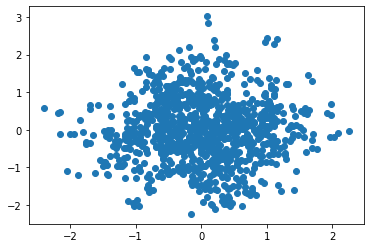

In [19]:
plt.scatter( torch.cat( my_samples,axis=2 )[0][0].numpy(), torch.cat( my_samples,axis=2 )[0][1].numpy() )
plt.show()

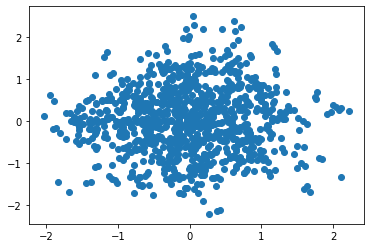

In [20]:
plt.scatter( torch.cat( my_samples,axis=2 )[1][0].numpy(), torch.cat( my_samples,axis=2 )[1][1].numpy() )
plt.show()